<a href="https://colab.research.google.com/github/omerhac/osic-fibrosis/blob/master/exponent_functions_eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# imports 
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# images path
IMAGES_GCS_PATH = 'gs://osic_fibrosis/images'

In [2]:
# clone and copy repository
!git clone https://github.com/omerhac/osic-fibrosis.git
!cp -r osic-fibrosis/* ./

Cloning into 'osic-fibrosis'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 387 (delta 6), reused 8 (delta 3), pack-reused 368
Receiving objects: 100% (387/387), 55.16 MiB | 11.69 MiB/s, done.
Resolving deltas: 100% (236/236), done.


# View one prediction graph

In [3]:
import predict 
import visualize

# plot one patient predicted graph
#exp_gen = predict.exponent_generator(IMAGES_GCS_PATH + '/train')
#id, func = next(exp_gen)
#visualize.plot_patient_exp(id, exp_function=func)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [63]:
import metrics

def metric_check(func_dict, n_patients, inifinite=False, theta=150):
    """Average n_patients random train patients Laplace Log Likelihood score"""
    scores = []

    # get scores
    for i, id in enumerate(func_dict):
        func = func_dict[id]

        # custom theta
        if isinstance(theta, dict):
          theta_now = theta[id]
        else:
          theta_now = theta
        score = metrics.get_lll_value_exp_function(id, func, theta=theta_now)
        scores.append(score)

        # exit rule
        if inifinite:
            print(score) # for infinitely printing scores
        else:
            if i == n_patients - 1:
                break

    return sum(scores) / n_patients
  
  
metric_check(func_dict, 170)

-6.442046429353045

# Check Laplace Log Lokilhood for ground truth coefficients

In [40]:
import table_data
exp_dict = table_data.get_exp_fvc_dict()
train_table = table_data.get_train_table()

# create exponent functiosn dict
func_dict = {}
for id in exp_dict:
  i_week, i_fvc = table_data.get_initial_fvc(id)
  func_dict[id] = predict.ExpFunc(i_fvc, exp_dict[id], i_week)


## Thats pretty close to the metric value we get from the CNN predicting the exponential coefficients. Thus, we should persue other methods for improving the model other then improving the CNN.

# Check how much effect does theta have

In [46]:
# get a very good theta 
theta_dict = {}
weeks_dict = {} # for later use

# iterate threw all train patients
for id in func_dict:
  hist = table_data.get_fvc_hist(train_table, id)
  theta = np.abs(hist["FVC"] - func_dict[id](hist["Weeks"])) # compute theta as the absolute diff of a prediction from ground truth
  theta_dict[id] = theta
  weeks_dict[id] = hist["Weeks"]

metric_check(func_dict, 170, theta=theta_dict) # best theta possible

-6.031767030104632

## So theta has a big inflence on the metric!
~ Now lets see if there is any pattern in theta against week number

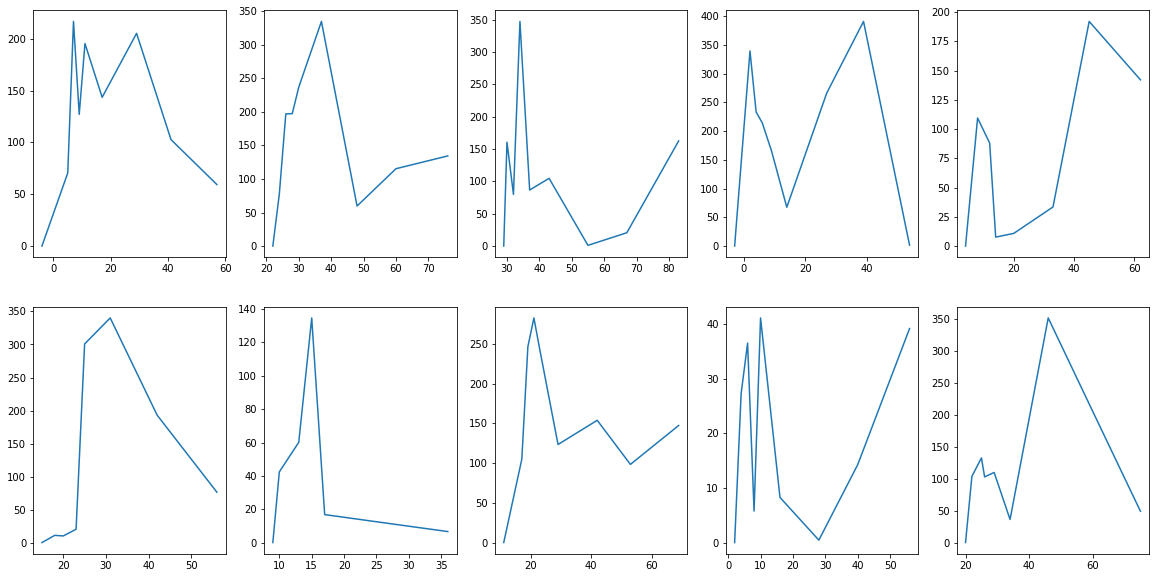

In [67]:
import math
N_SAMPLES = 10

# initiate plot
n_rows = math.ceil(N_SAMPLES / 5)
n_cols = 5
fig, ax = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))


# plot
for plot in range(N_SAMPLES):
  id = np.random.choice(list(theta_dict)) # generate random sample

  # get data
  theta = theta_dict[id]
  weeks = weeks_dict[id]

  # plot theta
  ax[plot // 5, plot % 5].plot(weeks, theta)

plt.show()

# Plot n_samples of ground truth exponent functions

<Figure size 1440x360 with 0 Axes>

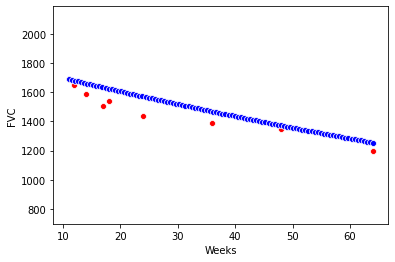

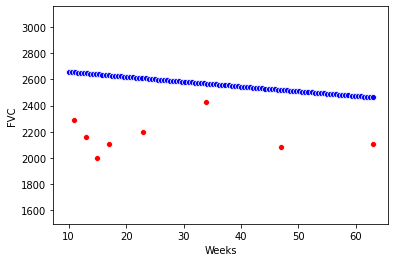

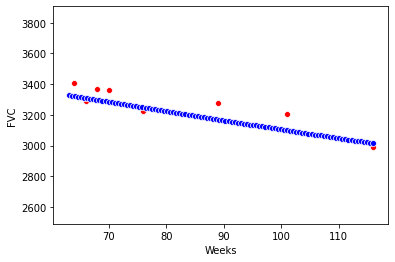

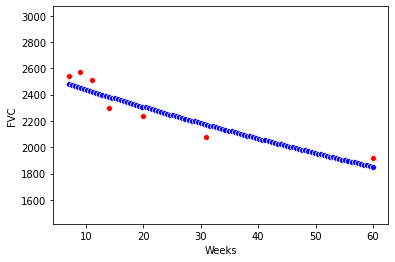

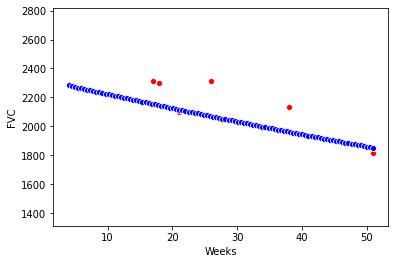

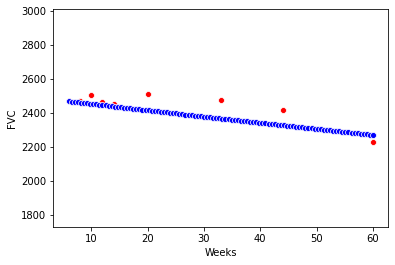

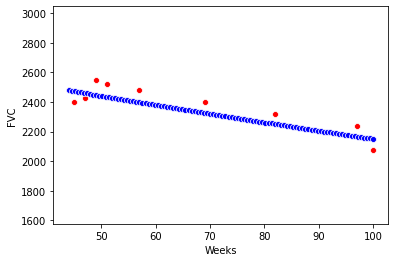

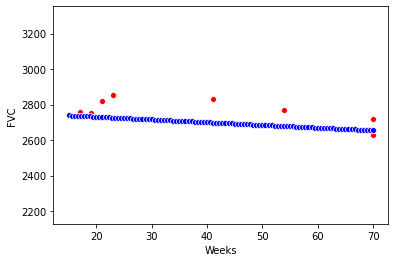

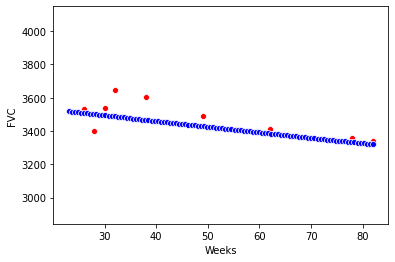

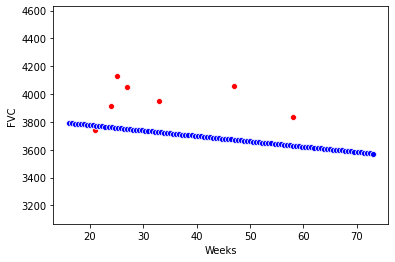

In [68]:
N_SAMPLES = 10

# plot
plt.figure(figsize=(20, 5))
for plot in range(N_SAMPLES):
  id = np.random.choice(list(func_dict))
  func = func_dict[id]
  visualize.plot_patient_exp(id, exp_function=func)

# Exemine outliers

In [ ]:
from statsmodels.formula.api import ols

for id in train_table["Patient"].unique()[20:30]:
  print(id)
  hist = table_data.get_fvc_hist(train_table, id)
  m = ols("FVC ~ Weeks", hist).fit() # fit a statsmodels ols
  visualize.plot_patient_exp(id, func_dict[id])
  infl = m.get_influence() # check influens on every point
  outliers = infl.summary_frame()["cooks_d"] # show cooks distance for every point
  print(outliers)

# Case study: Patient "ID00007637202177411956430"

In [ ]:
# visualize fvc
visualize.plot_patient_exp("ID00007637202177411956430")

In [ ]:
# visualize log of exp
hist = table_data.get_fvc_hist(train_table, "ID00007637202177411956430") # get hist
log_fvc = np.log(hist["FVC"])
plt.scatter(hist["Weeks"], log_fvc)

In [ ]:
# show cooks distance
log_hist = hist.copy()
log_hist["FVC"] = log_fvc
m = ols("FVC ~ Weeks", log_hist).fit() # fit ols
infl = m.get_influence()
cooks_d = infl.summary_frame()["cooks_d"]
print(cooks_d)

In [ ]:
points = np.linspace(1, 50, 25)
y = [np.exp(-0.05 * point) for point in points]
print(y)
plt.scatter(points, y)

In [ ]:
plt.scatter(points, np.log(y))